# COS401 Final Project

First, we import all necessary libraries and models.

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

!pip install transformers
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

from scipy.special import softmax

Then, we upload all the files that we'll use.

In [2]:
# https://drive.google.com/file/d/1oLLJO6Dp8Lpyg3wvn9-Sd6SIc_I81Q41/view?usp=sharing
!wget -q -O test_tweets.json "https://drive.google.com/uc?export=download&id=1oLLJO6Dp8Lpyg3wvn9-Sd6SIc_I81Q41"

# https://drive.google.com/file/d/1iV9qFSUuk11CrZ_Il-g76QgqzhHJAuFa/view?usp=sharing
!wget -q -O aug_2019.json "https://drive.google.com/uc?export=download&id=1iV9qFSUuk11CrZ_Il-g76QgqzhHJAuFa"

# https://drive.google.com/file/d/1-Bej7OUYUHDmJ2Kr3K00uYT0RNvVgAdm/view?usp=sharing
!wget -q -O aug_2019_sp.csv "https://drive.google.com/uc?export=download&id=1-Bej7OUYUHDmJ2Kr3K00uYT0RNvVgAdm"

## Part 1: Scraping & Processing Tweets

In [3]:
'''
parameters:
tweet_json, a json file of tweets

returns:
tweet_dates, a numpy array of the dates of the tweets, excluding weekends
tweet_tweets, a list containing lists of tweets per day, sorted by number of likes
'''
def tweet_data(tweet_json):
  df = pd.read_json(tweet_json)

  # drop unnecessary columns
  df.drop(labels=['id', 'isRetweet', 'retweets'], axis=1, inplace=True)

  # remove links, @'s, duplicate tweets, empty tweets (e.g. tweets that were only links)
  df['text'] = df['text'].apply(lambda x: re.sub(r"http\S+|www.\S+|\(@\S+", '', x))
  df.drop_duplicates(subset=['text'], inplace=True)
  df.drop(df[df.text.str.fullmatch('')].index, inplace=True)

  # reformat dates and remove weekends (stock market only open on weekdays)
  df['date'] = df['date'].dt.date
  df['date'] = pd.to_datetime(df['date'])
  df = df[df['date'].dt.weekday < 5]

  # sort tweets by day by number of likes
  df.sort_values(by=['date', 'favorites'], ascending=[True, False], inplace=True)

  # convert every day's tweets into a list, and make the index each day
  df = df.groupby('date')['text'].apply(list).reset_index()

  # convert all dates to numpy array, and add all lists of tweets into one list
  tweet_dates = df['date'].to_numpy()
  tweet_tweets = df['text'].to_list()

  return tweet_dates, tweet_tweets

## Part 2: Performing Sentiment Analysis

In [4]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [5]:
'''
parameters:
tweets, a list of tweets per day
n, the number of most-liked tweets we want to select
filter_trade, a boolean that indicates whether we want to filter by economy topic or not
filter_threshold, a probability threshold that the classification score must meet

returns:
filtered_tweets, a list of the tweets filtered as indicated by the parameters
'''
def filter_tweets(tweets, n=None, filter_trade=False, filter_threshold=0.5):
  topic_labels = ['economy', 'not economy']
  topic_tweets = []
  filtered_tweets = []

  # use the classifier to label every tweet
  if filter_trade is True:
    for tweet in tweets:
      class_dict = classifier(tweet, topic_labels)
      if class_dict['labels'][0] == 'economy' and class_dict['scores'][0] > filter_threshold:
        topic_tweets.append(tweet)

  if len(topic_tweets) == 0:
    filtered_tweets = tweets
  else:
    filtered_tweets = topic_tweets

  # only take the top n tweets
  if n is not None:
    if len(filtered_tweets) > n:
      filtered_tweets = filtered_tweets[:n]

  return filtered_tweets

In [6]:
'''
parameters:
tweets, a list of tweets per day (usually post-filter)

returns:
scores, a list containing lists of (softmaxed) scores per label for every tweet after sentiment analysis
'''
def sentiment_score(tweets):
  encoded_input = tokenizer(text=tweets, return_tensors='pt', padding=True)
  output = model(**encoded_input)

  # obtain logits and convert to numpy
  logits = output['logits'].detach().numpy()

  # take the softmax across all the possible labels
  scores = softmax(logits, axis=1)

  return scores

In [7]:
'''
parameters:
scores_per_day, a list containing lists of (softmaxed) scores per label for every tweet after sentiment analysis
label, the label that we want to obtain scores for
stat, the way in which we want to calculate the single score per day

returns:
day_sentiment, a single sentiment score for one day
'''
def sentiment_per_day(scores_per_day, label='positive', stat='mean'):
  label_list = ['negative', 'neutral', 'positive']
  label_index = label_list.index(label)

  # obtain labels of interest
  label_column = scores_per_day[:,label_index]

  # calculate appropriate statistic and round
  if stat == 'mean':
    day_sentiment = np.mean(label_column)
  elif stat == 'median':
    day_sentiment = np.median(label_column)
  elif stat == 'max':
    day_sentiment = np.max(label_column)

  day_sentiment = round(day_sentiment.item(), 4)

  return day_sentiment

In [8]:
'''
parameters:
tweets, a list containing lists of tweets per day
n, the number of most-liked tweets we want to select
filter_trade, a boolean that indicates whether we want to filter by economy topic or not
filter_threshold, a probability threshold that the classification score must meet
label, the label that we want to obtain scores for
stat, the way in which we want to calculate the single score per day

returns:
sentiments_list, a list of sentiment scores per day over the whole period
'''
def sentiment_per_period(tweets, n=None, filter_trade=False, filter_threshold=0.5, label='positive', stat='mean'):
  sentiments_list = []

  # for every batch of tweets per day, filter tweets, obtain scores and convert to a single score per day
  for day_tweets in tweets:
    day_filter_tweets = filter_tweets(day_tweets, n=n, filter_trade=filter_trade, filter_threshold=filter_threshold)
    day_filter_scores = sentiment_score(day_filter_tweets)
    day_sentiment_score = sentiment_per_day(day_filter_scores, label=label, stat=stat)
    sentiments_list.append(day_sentiment_score)

  sentiments_list = np.array(sentiments_list)

  return sentiments_list


## Part 3: Processing Stock Market Data

In [9]:
'''
parameters:
csv_file, a csv file of stock market data

returns:
stock_dates, a numpy array of the stock market dates
stock_close, a numpy array of the closing index per day
'''
def stock_data(csv_file):
  stock_df = pd.read_csv(csv_file)
  stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
  stock_df['Close'] = stock_df['Close'].str.replace(',', '')
  stock_df['Close'] = pd.to_numeric(stock_df['Close'], errors='coerce')
  stock_df.sort_values(by=['Date'], ascending=True, inplace=True)

  stock_dates = stock_df['Date'].to_numpy()
  stock_close = stock_df['Close'].to_numpy()

  return stock_dates, stock_close

In [10]:
'''
parameters:
tweet_dates, a numpy array of the tweet dates
tweet_tweets, a list containing lists of tweets per day, sorted by number of likes
stock_dates, a numpy array of the stock market dates

returns:
new_tweet_tweets, a list containing lists of tweets per day, sorted by number of likes, but with non-market days excluded
'''
def remove_dates(tweet_dates, tweet_tweets, stock_dates):
  new_tweet_tweets = []

  for i, date in enumerate(tweet_dates):
    conv_date = ((date - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's'))
    conv_date = dt.datetime.utcfromtimestamp(conv_date)
    conv_date = conv_date.date()

    if conv_date in stock_dates:
      new_tweet_tweets.append(tweet_tweets[i])

  return new_tweet_tweets

## Part 4: Graphing

In [11]:
'''
parameters:
stock_dates, a numpy array of the stock market dates, excluding weekends
stock_close, a numpy array of the closing index per day
sentiments, a list of sentiment scores per day over the same period

returns nothing, but draws sentiment scores and stock market index on the same graph
'''
def plot_creater(stock_dates, stock_close, sentiments):
  fig, ax1 = plt.subplots(figsize=(6,4))
  index, = ax1.plot(stock_dates, stock_close, color='blue', label='S&P 500')
  ax1.set_xlabel('Time')
  ax1.set_ylabel('Closing index')

  plt.xticks(rotation=45)

  ax2 = ax1.twinx()
  sentiment, = ax2.plot(stock_dates, sentiments, color='red', label='sentiment score')
  ax2.set_ylabel('Sentiment score')

  fig.legend(handles=[index, sentiment], labels=['S&P 500', 'sentiment score'], loc='upper left')

  plt.title('Closing index over time \n & sentiment score over time')

## Part 5: Changing Settings

We can try with August 2019. Notably, August 23 was when China retaliated against Trump's tariffs.

Source: [Peterson Institute for International Economics](https://www.piie.com/blogs/trade-and-investment-policy-watch/us-china-trade-war-guns-august)

### Mean, maximum, or median

First, we'll try with the top 5 tweets from August 2019, filtered by the economy topic, and graph their mean positive sentiment scores per day against the S&P 500 stock index per day over the same month.

In [ ]:
aug_tweet_dates, aug_tweet_tweets = tweet_data('aug_2019.json')
aug_stock_dates, aug_stock_close = stock_data('aug_2019_sp.csv')
aug_sentiments_mean = sentiment_per_period(aug_tweet_tweets, n=5, filter_trade=True, filter_threshold=0.5, label='positive', stat='mean')

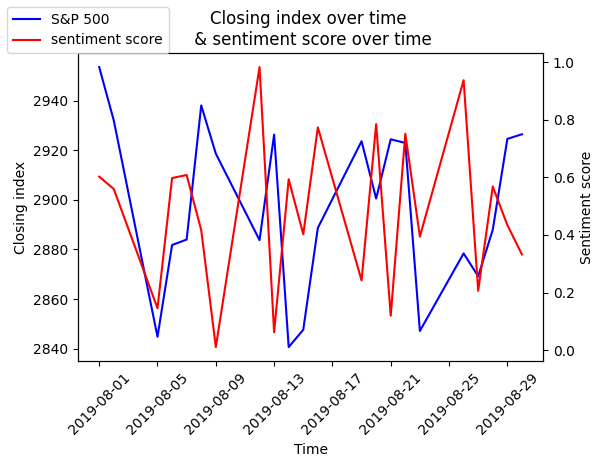

In [ ]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_mean)

In [ ]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_mean)[0][1]}")

The correlation coefficient is -0.12320231664042378


Now we can try with only taking the maximum positive sentiment score.

In [ ]:
aug_tweet_dates, aug_tweet_tweets = tweet_data('aug_2019.json')
aug_stock_dates, aug_stock_close = stock_data('aug_2019_sp.csv')
aug_sentiments_max = sentiment_per_period(aug_tweet_tweets, n=5, filter_trade=True, filter_threshold=0.5, label='positive', stat='max')

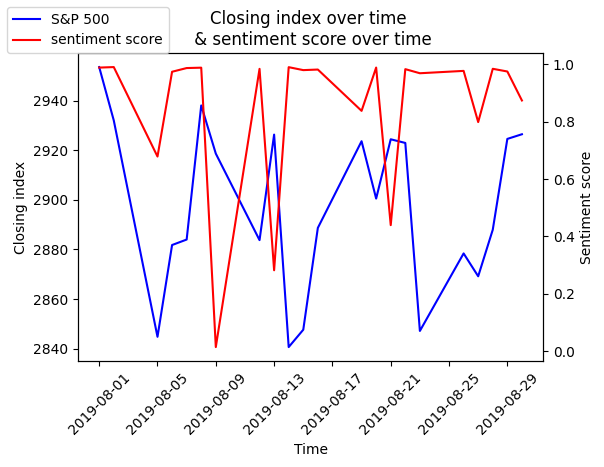

In [ ]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_max)

In [ ]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_max)[0][1]}")

The correlation coefficient is -0.2108785817826838


Finally, the median.

In [12]:
aug_tweet_dates, aug_tweet_tweets = tweet_data('aug_2019.json')
aug_stock_dates, aug_stock_close = stock_data('aug_2019_sp.csv')
aug_sentiments_med = sentiment_per_period(aug_tweet_tweets, n=5, filter_trade=True, filter_threshold=0.5, label='positive', stat='median')

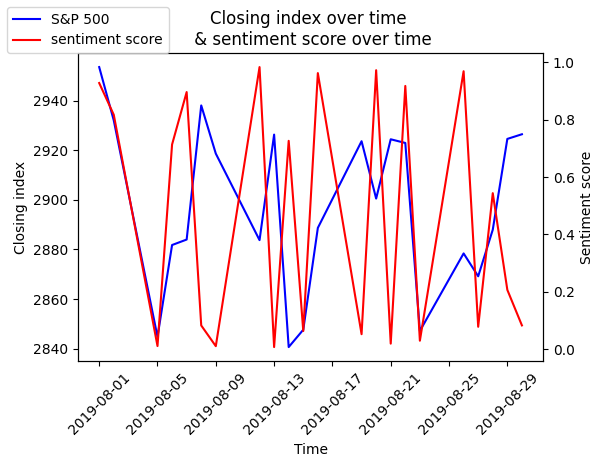

In [13]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_med)

In [14]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_med)[0][1]}")

The correlation coefficient is 0.007974865270107814


So, taking the median gives the strongest correlation (which is not very surprising).

### Changing *n*

I first wanted to try with selecting the single most popular tweet under the economy topic.

In [ ]:
aug_tweet_dates, aug_tweet_tweets = tweet_data('aug_2019.json')
aug_stock_dates, aug_stock_close = stock_data('aug_2019_sp.csv')
aug_sentiments_n1 = sentiment_per_period(aug_tweet_tweets, n=1, filter_trade=True, filter_threshold=0.5, label='positive', stat='mean')

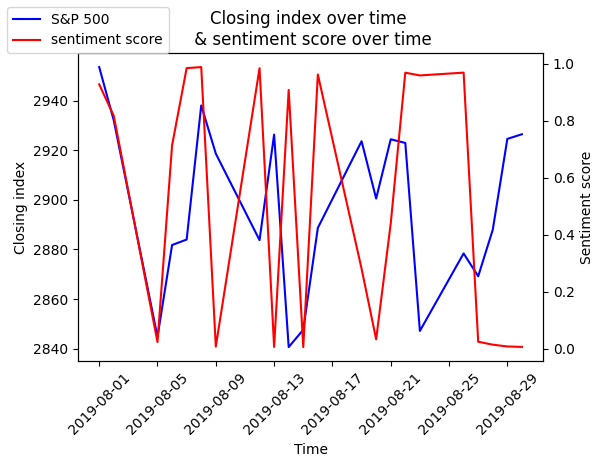

In [ ]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_n1)

In [ ]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_n1)[0][1]}")

The correlation coefficient is -0.007468236428811336


Between *n*=1 and *n*=5?

In [15]:
aug_tweet_dates, aug_tweet_tweets = tweet_data('aug_2019.json')
aug_stock_dates, aug_stock_close = stock_data('aug_2019_sp.csv')
aug_sentiments_n3 = sentiment_per_period(aug_tweet_tweets, n=3, filter_trade=True, filter_threshold=0.5, label='positive', stat='median')

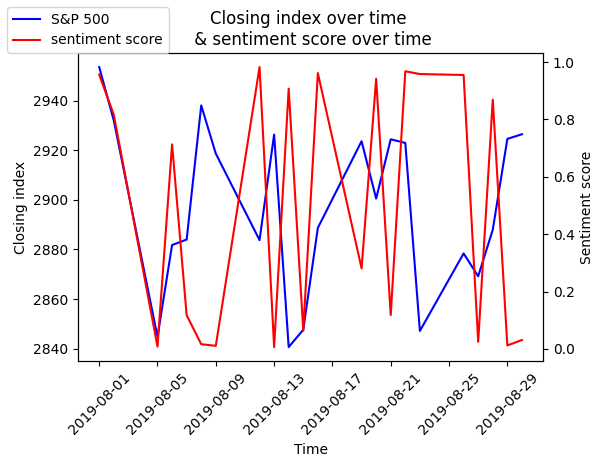

In [16]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_n3)

In [17]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_n3)[0][1]}")

The correlation coefficient is -0.13869661409234957


What about *n*=10?

In [12]:
aug_tweet_dates, aug_tweet_tweets = tweet_data('aug_2019.json')
aug_stock_dates, aug_stock_close = stock_data('aug_2019_sp.csv')
aug_sentiments_n10 = sentiment_per_period(aug_tweet_tweets, n=10, filter_trade=True, filter_threshold=0.5, label='positive', stat='median')

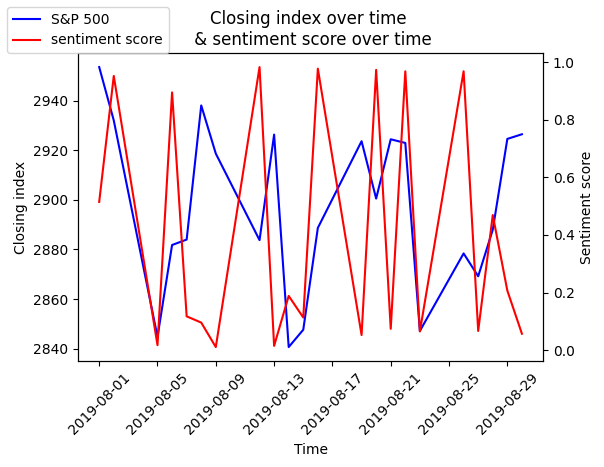

In [13]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_n10)

In [14]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_n10)[0][1]}")

The correlation coefficient is 0.07276932553595192


I also wanted to try when *n* is None, which means that I take the median sentiment score across all tweets under the economy topic per day.

In [18]:
aug_sentiments_n_none = sentiment_per_period(aug_tweet_tweets, n=None, filter_trade=True, filter_threshold=0.5, label='positive', stat='median')

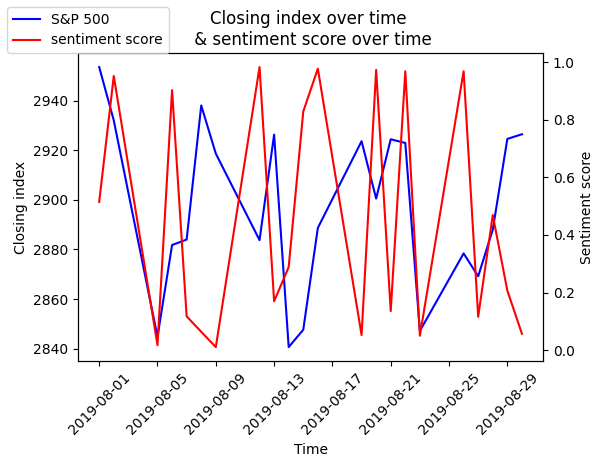

In [19]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_n_none)

In [20]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_n_none)[0][1]}")

The correlation coefficient is -0.05595236318215898


The correlation is stronger when we only select the most popular 10 tweets of the day.

### Changing topic filter

In [15]:
aug_tweet_dates, aug_tweet_tweets = tweet_data('aug_2019.json')
aug_stock_dates, aug_stock_close = stock_data('aug_2019_sp.csv')
aug_sentiments_no_econ = sentiment_per_period(aug_tweet_tweets, n=10, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

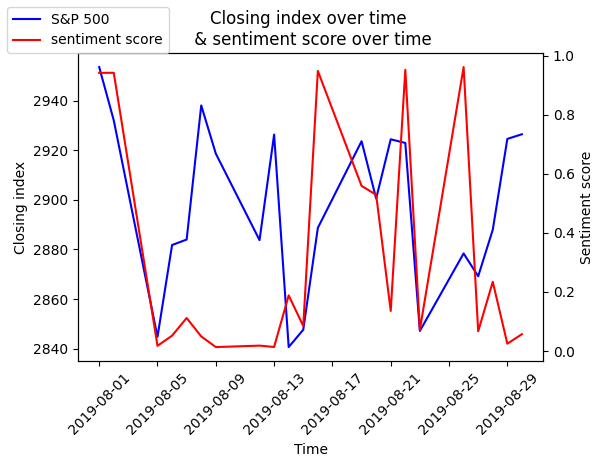

In [16]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_no_econ)

In [17]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_no_econ)[0][1]}")

The correlation coefficient is 0.3025784433189282


The correlation coefficient is higher than when we filter by topic, which is surprising. I thought this might be because the classification filter often sorts tweets that are only tangentially related to the economy to fall under the economy topic, so I changed the classification threshold below.

### Filter threshold

Raising the threshold to 0.6:

In [12]:
aug_tweet_dates, aug_tweet_tweets = tweet_data('aug_2019.json')
aug_stock_dates, aug_stock_close = stock_data('aug_2019_sp.csv')
aug_sentiments_ft06 = sentiment_per_period(aug_tweet_tweets, n=10, filter_trade=True, filter_threshold=0.6, label='positive', stat='median')

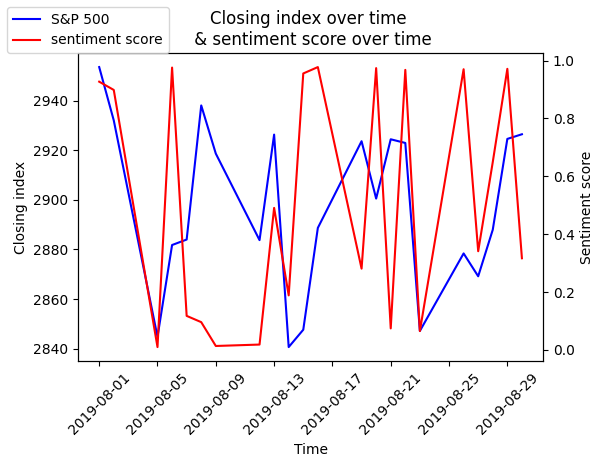

In [13]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_ft06)

In [14]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_ft06)[0][1]}")

The correlation coefficient is 0.17736719227073375


Raising the threshold to 0.7:

In [31]:
aug_sentiments_ft07 = sentiment_per_period(aug_tweet_tweets, n=10, filter_trade=True, filter_threshold=0.7, label='positive', stat='median')

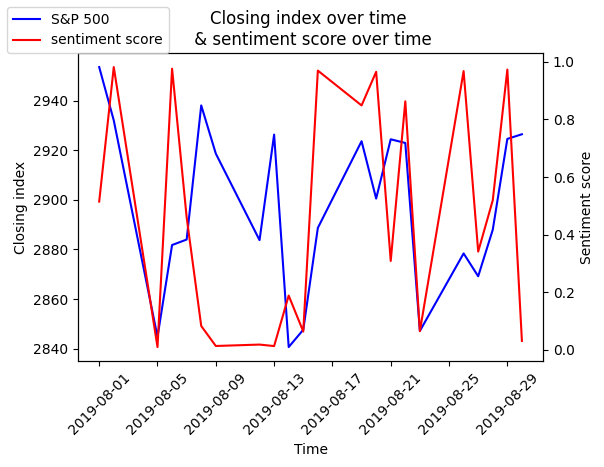

In [32]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_ft07)

In [33]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_ft07)[0][1]}")

The correlation coefficient is 0.2379436204888764


Raising the threshold to 0.8:

In [34]:
aug_sentiments_ft08 = sentiment_per_period(aug_tweet_tweets, n=10, filter_trade=True, filter_threshold=0.8, label='positive', stat='median')

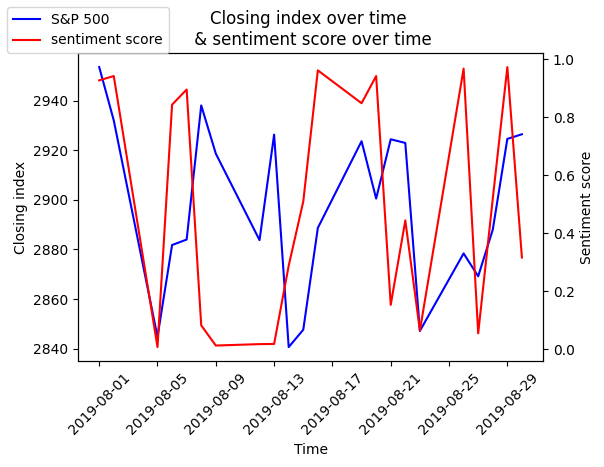

In [35]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_ft08)

In [36]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_ft08)[0][1]}")

The correlation coefficient is 0.2128324207349284


Finally, to 0.9:

In [15]:
aug_sentiments_ft09 = sentiment_per_period(aug_tweet_tweets, n=10, filter_trade=True, filter_threshold=0.9, label='positive', stat='median')

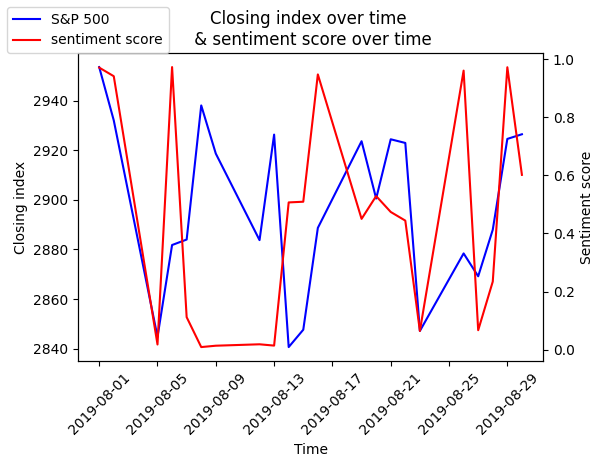

In [16]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_ft09)

In [17]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_ft09)[0][1]}")

The correlation coefficient is 0.23437220426957253


The correlation coefficient seems to peak at around 0.7.

### Removing topic filter & changing *n*

Still, removing the topic filter completely actually introduces the most correlation in comparison to all the other options.

First, try *n*=1.

In [61]:
aug_sentiments_no_econ_n1 = sentiment_per_period(aug_tweet_tweets, n=1, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

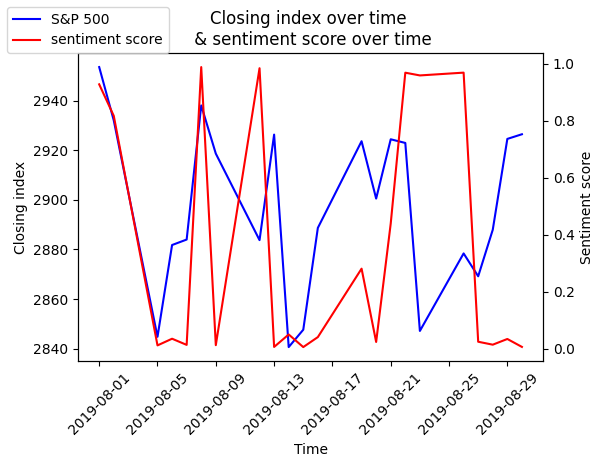

In [62]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_no_econ_n1)

In [64]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_no_econ_n1)[0][1]}")

The correlation coefficient is 0.2606924517031241


Then try *n*=5.

In [52]:
aug_sentiments_no_econ_n5 = sentiment_per_period(aug_tweet_tweets, n=5, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

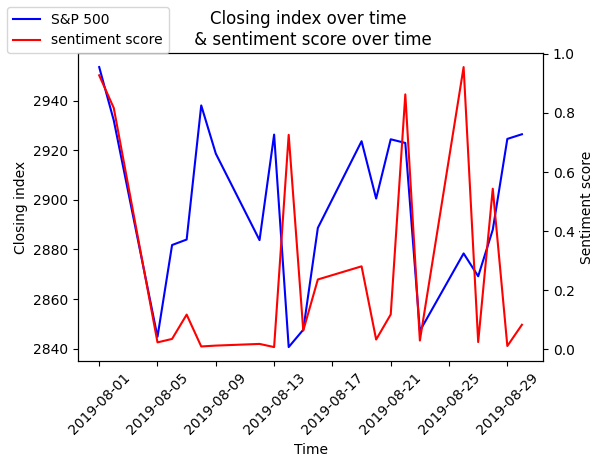

In [53]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_no_econ_n5)

In [54]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_no_econ_n5)[0][1]}")

The correlation coefficient is 0.1631042581200437


And then *n*=10.

In [55]:
aug_sentiments_no_econ_n10 = sentiment_per_period(aug_tweet_tweets, n=10, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

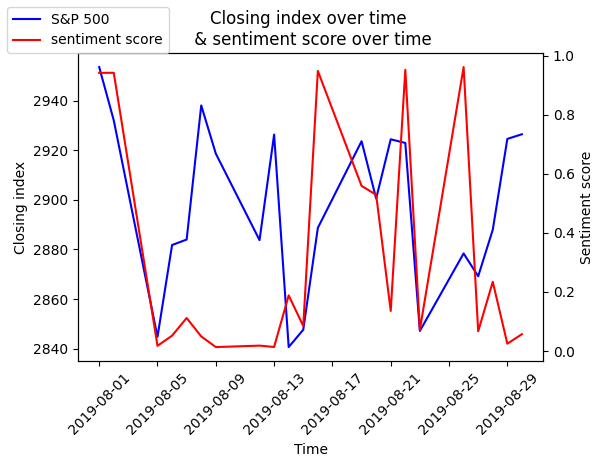

In [56]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_no_econ_n10)

In [57]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_no_econ_n10)[0][1]}")

The correlation coefficient is 0.3025784433189282


Finally, all tweets per day (*n*=None).

In [58]:
aug_sentiments_no_econ_n_none = sentiment_per_period(aug_tweet_tweets, n=None, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

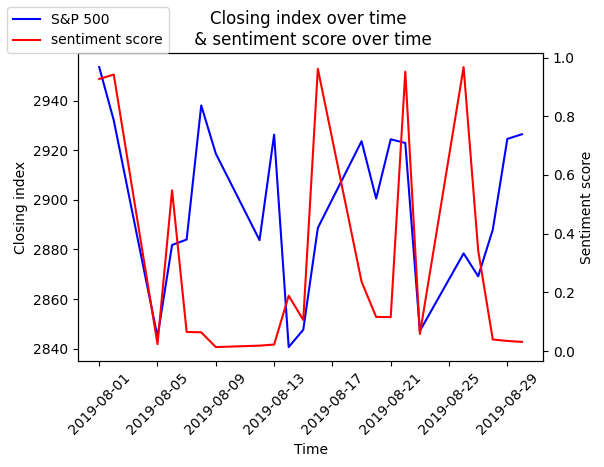

In [59]:
plot_creater(aug_stock_dates, aug_stock_close, aug_sentiments_no_econ_n_none)

In [60]:
print(f"The correlation coefficient is {np.corrcoef(aug_stock_close, aug_sentiments_no_econ_n_none)[0][1]}")

The correlation coefficient is 0.21218854858326056


*n*=10 is still best.

## Part 6: Other months

In [65]:
# https://drive.google.com/file/d/1Tp-dI0bl8oIjsROteQNFLiN3Yg5_pnZO/view?usp=sharing
!wget -q -O feb_2017.json "https://drive.google.com/uc?export=download&id=1Tp-dI0bl8oIjsROteQNFLiN3Yg5_pnZO"

# https://drive.google.com/file/d/1IrUC9hZkru0h9-1sYhCOkWT21fwNy7Eh/view?usp=sharing
!wget -q -O feb_2017_sp.csv "https://drive.google.com/uc?export=download&id=1IrUC9hZkru0h9-1sYhCOkWT21fwNy7Eh"

In [66]:
feb_tweet_dates, feb_tweet_tweets = tweet_data('feb_2017.json')
feb_stock_dates, feb_stock_close = stock_data('feb_2017_sp.csv')

For February specifically, the market is closed on holidays, so I deleted some more tweets.

In [67]:
feb_tweet_tweets = remove_dates(feb_tweet_dates, feb_tweet_tweets, feb_stock_dates)

When *n*=1:

In [68]:
feb_sentiments_no_econ_n1 = sentiment_per_period(feb_tweet_tweets, n=1, filter_trade=False, filter_threshold=0.5, label='positive', stat='mean')

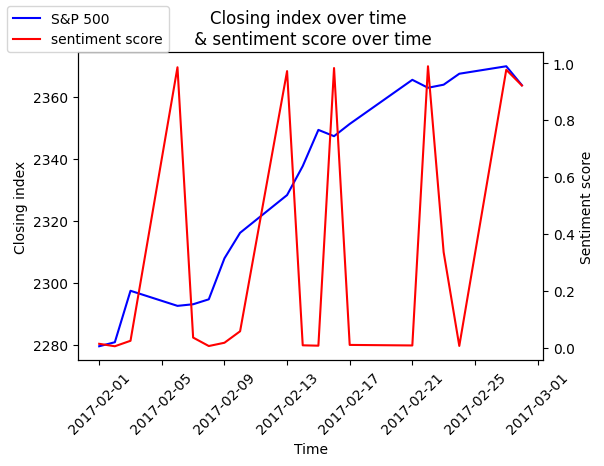

In [69]:
plot_creater(feb_stock_dates, feb_stock_close, feb_sentiments_no_econ_n1)

In [70]:
print(f"The correlation coefficient is {np.corrcoef(feb_stock_close, feb_sentiments_no_econ_n1)[0][1]}")

The correlation coefficient is 0.33382049951954873


We can also try when *n*=10.

In [71]:
feb_sentiments_no_econ_n10 = sentiment_per_period(feb_tweet_tweets, n=10, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

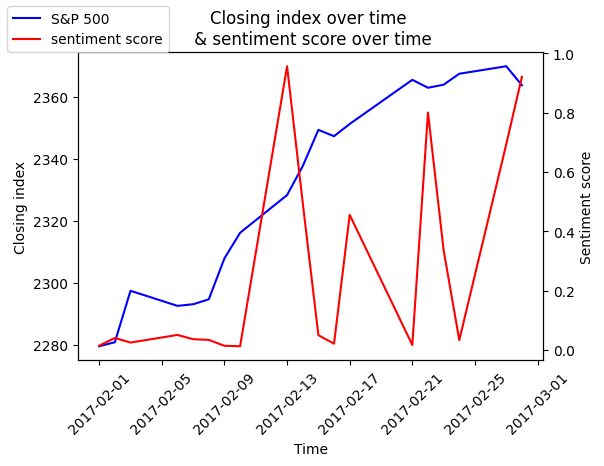

In [72]:
plot_creater(feb_stock_dates, feb_stock_close, feb_sentiments_no_econ_n10)

In [73]:
print(f"The correlation coefficient is {np.corrcoef(feb_stock_close, feb_sentiments_no_econ_n10)[0][1]}")

The correlation coefficient is 0.5044230952242567


Or when *n*=None.

In [74]:
feb_sentiments_no_econ_n_none = sentiment_per_period(feb_tweet_tweets, n=None, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

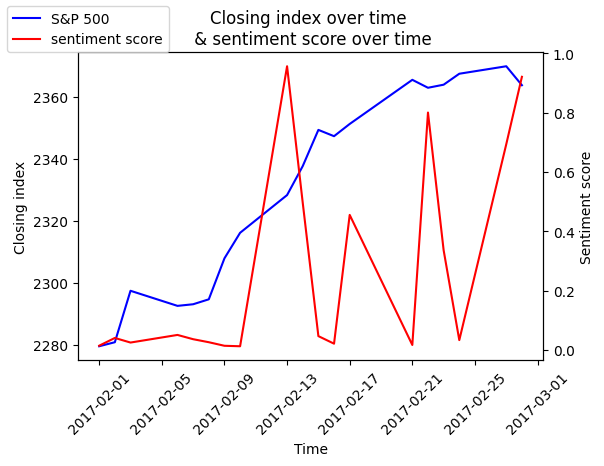

In [75]:
plot_creater(feb_stock_dates, feb_stock_close, feb_sentiments_no_econ_n_none)

In [76]:
print(f"The correlation coefficient is {np.corrcoef(feb_stock_close, feb_sentiments_no_econ_n_none)[0][1]}")

The correlation coefficient is 0.5049157027541404


The stock market was generally increasing during this time, which makes for rather boring results.

In April 2018, China responded to the first Trump administration's tariffs on solar panels from China by levying tariffs of their own. The next day, Trump implemented a 25% tax on Chinese aerospace, machinery and medical industries.

Source: [AP News](https://apnews.com/article/china-us-tariffs-timeline-trump-xi-1eeed2865dc7b14e23d7eb8069ba41ea)



In [77]:
# https://drive.google.com/file/d/1MVmZEYv2A4ECt5ip7I70fGTZq4YyzC9S/view?usp=sharing
!wget -q -O apr_2018.json "https://drive.google.com/uc?export=download&id=1MVmZEYv2A4ECt5ip7I70fGTZq4YyzC9S"

# https://drive.google.com/file/d/1D60fGiwda9RT8do45LaKFhWfhIhadSUs/view?usp=sharing
!wget -q -O apr_2018_sp.csv "https://drive.google.com/uc?export=download&id=1D60fGiwda9RT8do45LaKFhWfhIhadSUs"

In [78]:
apr_tweet_dates, apr_tweet_tweets = tweet_data('apr_2018.json')
apr_stock_dates, apr_stock_close = stock_data('apr_2018_sp.csv')

In [79]:
apr_tweet_tweets = remove_dates(apr_tweet_dates, apr_tweet_tweets, apr_stock_dates)

First, *n*=1.

In [80]:
apr_sentiments_no_econ_n1 = sentiment_per_period(apr_tweet_tweets, n=1, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

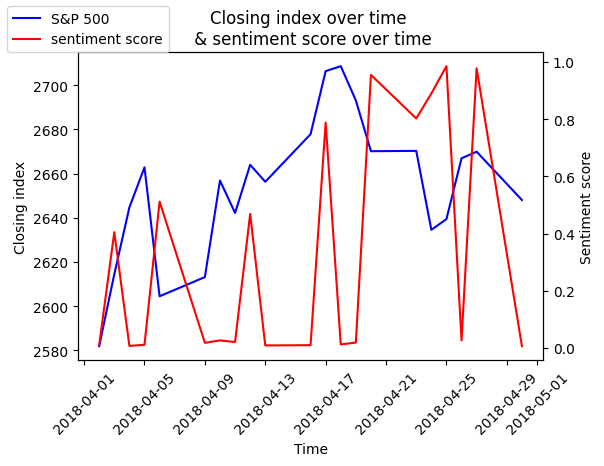

In [81]:
plot_creater(apr_stock_dates, apr_stock_close, apr_sentiments_no_econ_n1)

In [82]:
print(f"The correlation coefficient is {np.corrcoef(apr_stock_close, apr_sentiments_no_econ_n1)[0][1]}")

The correlation coefficient is 0.07696472810618965


Then, *n*=10.

In [83]:
apr_sentiments_no_econ_n10 = sentiment_per_period(apr_tweet_tweets, n=10, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

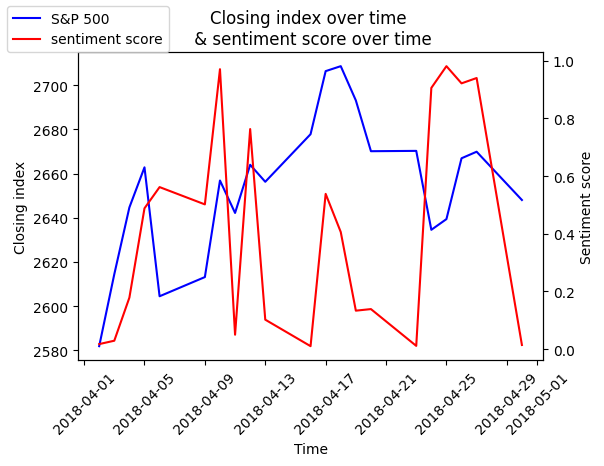

In [84]:
plot_creater(apr_stock_dates, apr_stock_close, apr_sentiments_no_econ_n10)

In [85]:
print(f"The correlation coefficient is {np.corrcoef(apr_stock_close, apr_sentiments_no_econ_n10)[0][1]}")

The correlation coefficient is 0.07611488525948933


Finally, *n*=None.

In [86]:
apr_sentiments_no_econ_n_none = sentiment_per_period(apr_tweet_tweets, n=None, filter_trade=False, filter_threshold=0.5, label='positive', stat='median')

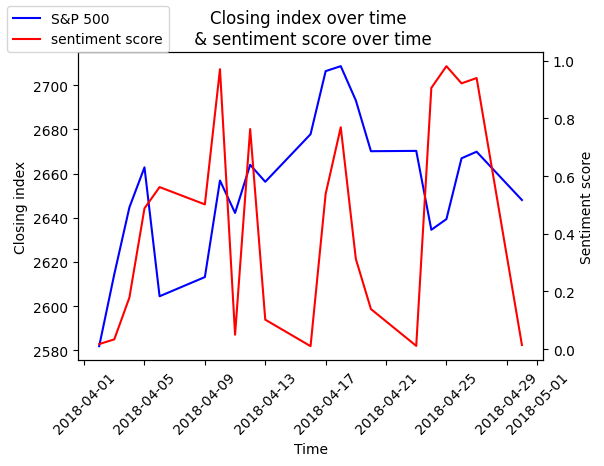

In [87]:
plot_creater(apr_stock_dates, apr_stock_close, apr_sentiments_no_econ_n_none)

In [88]:
print(f"The correlation coefficient is {np.corrcoef(apr_stock_close, apr_sentiments_no_econ_n_none)[0][1]}")

The correlation coefficient is 0.18618931088407398
